# _**ColabCuraTE**_ v1.0.1
_An easy-to-use pipeline for manual curation of transposable elements_

# **INTRODUCTION**
#### This colab notebook is a pipeline for the manual curation of transposable elements (TEs).

#### Requirements:
*   A genome assembly file (_fasta_ format) from an organism of interest.
*   A repeat library file (_fasta_ format) from the same organism, generated using a TE discovery and annotation tool (e.g., the `XXX-families.fa` file output from [_RepeatModeler2_](https://pubmed.ncbi.nlm.nih.gov/32300014/)).
*   The name of a specific TE family from the repeat library to curate

#### Output:
*   An improved, full length consensus sequence (_fasta_ format) for the TE family of interest.
*   An updated _stockholm_ formatted (`.stk`) seed alignment file which can be deposited in the [_Dfam_ TE database](https://www.dfam.org/).

#### Pipeline steps:
1.   [Load input files and install software packages.](#scrollTo=a9ac66j1bFmc)
2.   [Select a TE family of interest and extract, align, and extend individual copies](#scrollTo=7oqZir_3UZC6)
      - Extract a TE consensus sequence from the repeat library.
      - Identify all of its copies in the genome.
      - Align TE copies to create a _seed alignment_.
      - Perform initial extension of TE copy boundaries
3.   [Align and inspect extended copies](#scrollTo=-RPOn2J0UZDP)
      - Create a new _seed alignment_ from extended TE copies
      - Visualize the alignment to identify TE boundaries
      - Iteratively extend TE copies until boundaries are identified
4.   [Precise identification of TE boundaries](#scrollTo=xFIVEWHycIy1)
      - Search for Target Site Duplications (TSDs) to help identify exact TE boundaries
      - Trim the alignment down to the TE boundaries
      - Create a new, extended, consensus.
5.   [Generation of final output files](#scrollTo=a9b2pa29qpJG)
      - Reclassify the final consensus sequence.
      - Create a final _stockholm_ formatted (`.stk`) seed alignment ready for _Dfam_ accessioning.
6.   [Analysis of consensus sequence](#scrollTo=JbUG2xtik5Pq)
      - Compare the original and updated consensus sequences
      - Analysis of updated consensus sequence with [_TE-Aid_](https://github.com/clemgoub/TE-Aid)
7.   [Appendix](#scrollTo=5cgS2J8ZNa1D)
      - Running _RepeatModeler2_ and _RepeatMasker_ on [_Galaxy_](https://usegalaxy.org/)
      - Creation of repeat landscape plots
      - Generate interactive table of summary statistics for all TE families


# **PART 1. LOAD FILES & INSTALL SOFTWARE PACKAGES**

In [1]:
#@title 1.1) COPY FILES FROM GOOGLE DRIVE
#@markdown _Run this cell to mount your google drive to this notebook. Follow the instructions in the popup windows to allow access._
#@markdown >**_IMPORTANT_**: To successfully mount your google drive, you must click **_Select all_** when prompted to **_Select what Google Drive for desktop can access_**. If you have concerns about allowing this notebook to access your google drive, we recommend that you either create a new google account that you use only for _Colab_ or follow the **_Direct Upload_** instructions below.
#@markdown #### Mounting your **Google Drive** is beneficial for two key reasons:
#@markdown
#@markdown 1. **More reliable uploads**: Transfer of large genome files directly from your local device can be interrupted, resulting in a truncated file. Uploading from Google Drive avoids this issue.
#@markdown 2. **Automatic file saving**: Several steps save backup copies of important files to your Google Drive. These backups help prevent data loss if the Colab runtime times out after the step completes.
#@markdown
#@markdown

#@markdown ### Required Google Drive File Structure
#@markdown Before starting, please create the following folders inside your main `MyDrive` folder:
#@markdown ```
#@markdown MyDrive/TE_curation_files
#@markdown MyDrive/TE_curation_files/genomes
#@markdown MyDrive/TE_curation_files/repeat_libraries
#@markdown MyDrive/TE_curation_files/stks
#@markdown MyDrive/TE_curation_files/extended_alignments
#@markdown MyDrive/TE_curation_files/curated_families
#@markdown ```
#@markdown
#@markdown Place your **genome file** in:
#@markdown `MyDrive/TE_curation_files/genomes/`
#@markdown
#@markdown Place your **repeat library file** in:
#@markdown `MyDrive/TE_curation_files/repeat_libraries/`
#@markdown
#@markdown >_If you’ve previously run Step 2.2 (seed alignment), you can use the step below to load an autosaved `.stk` alignment file from: `MyDrive/TE_curation_files/stks`_

#@markdown >_If you’ve previously run Step 3 (alignment extension), you can use the step below to load an autosaved `.fa` extended alignment file from: `MyDrive/TE_curation_files/extended_alignments`_

#@markdown ### Your google drive file structure should now appear as below:
#@markdown ```
#@markdown MyDrive/
#@markdown └── TE_curation_files/
#@markdown     ├── genomes/
#@markdown     │   └── your_genome.fasta
#@markdown     ├── repeat_libraries/
#@markdown     │   └── your_repeat_library.fasta
#@markdown     ├── stks/
#@markdown     │   └── your seed alignments will be autosaved here
#@markdown     ├── extended_alignments/
#@markdown     │   └── your extended alignments will be saved here
#@markdown     └── curated_families/
#@markdown         └── your final curated TE family files will be saved here
#@markdown ```


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@markdown ##### Run this cell to copy your files over from Google Drive
#@markdown - Edit below to specify the file names of your genome and repeat library in your Google Drive folders.

genome="dmel.fasta" #@param {type:"string"}
repeat_library="dmel_hiTE-families.fa" #@param {type:"string"}
#@markdown If you want to load a previously saved seed alignment from `MyDrive/TE_curation_files/stks`, enter the filename below, otherwise enter `None`.
seed_alignment="None" #@param {type:"string"}
#@markdown If you want to load a previously saved extended alignment from `MyDrive/TE_curation_files/extended_alignments`, enter the filename below, otherwise enter `None`.
extended_alignment="None" #@param {type:"string"}

!cp /content/drive/MyDrive/TE_curation_files/genomes/$genome .
!cp /content/drive/MyDrive/TE_curation_files/repeat_libraries/$repeat_library .
if seed_alignment != "None":
    !cp /content/drive/MyDrive/TE_curation_files/stks/{seed_alignment} .
if extended_alignment != "None":
    !cp /content/drive/MyDrive/TE_curation_files/extended_alignments/{extended_alignment} .

In [ ]:
#@title ALTERNATIVE TO STEP 1.1) DIRECT FILE UPLOAD (NOT PREFERRED)
#@markdown
#@markdown **If you prefer not to use Google Drive:** you must manually upload your input files and manually download any output files you want to keep.
#@markdown
#@markdown **Direct upload instructions (genome & TE library):**
#@markdown 1) Click the **folder** icon (left sidebar) to open *Files*.
#@markdown 2) Click **Upload** and select your **genome FASTA** and your **TE library FASTA** from your computer. While uploading, check the progress bar on the bottom left corner of this notebook to see upload status.
#@markdown 3) After upload, confirm the files appear in `/content/` and enter the genome name in the **Genome Size Check** box below. Then run this cell to confirm your genome was fully uploaded.
#@markdown
#@markdown
#@markdown **Direct download instructions:**
#@markdown - Open the **Files** panel (click the **folder** icon on the far-left sidebar).
#@markdown - Find your file under `/content/`.
#@markdown - Click the **three dots** next to the filename → **Download**.
#@markdown ---

#@markdown **Genome Size Check:** After uploading your genome FASTA manually, enter the filename below to calculate the size of the uploaded genome. To confirm that the upload was not truncated, verify that the reported size matches the expected size.

genome = ""  #@param {type:"string"}

import os
from Bio import SeqIO

def _fmt_bytes(n: int) -> str:
    gb = n / (1e9)
    mb = n / (1e6)
    if gb >= 1:
        return f"{gb:.2f} Gigabase pairs"
    if mb >= 1:
        return f"{mb:.2f} Megabase pairs"
    return f"{n} base pairs"

print("=== Direct Upload: Genome File Check ===")
if os.path.exists(genome):
    size=0
    for record in SeqIO.parse(genome,"fasta"):
        size+=len(record)
    print(f"Genome file: {genome}")
    print(f" - Size: {_fmt_bytes(size)}")
    print(">> Confirm this size matches your expected genome size. If it looks too small, the upload may have been interrupted/truncated.")
else:
    print(f"Genome file not found at /content: {genome}")
    print("• Ensure you used the folder icon → Upload, and that the filename above matches exactly (case-sensitive).")


### Please be aware of the following:
- Your input files and any output files generated during this pipeline will be stored in the `/content` directory of this notebook. Expand the folder icon on the left side of the notebook to see the files/folders present in the `/content` directory for this current runtime.

- All files in the `/content` directory of this notebook will be deleted when the runtime expires or is terminated, which occurs if the notebook is idle for 90 minutes or when the maximum session length (12 hours) is reached. We introduce several checkpoints below to back up important files but any file can be saved at any time. To save a file, expand the folder icon on the left side of the notebook, click the three dots that appear when you hover over the filename and select _Download_.

- It may take some time for the `/contents` folder to automatically refresh and display newly created files. In this case, use the _Refresh_ icon to manually refresh the directory.

In [3]:
#@title 1.2) INSTALL SOFTWARE DEPENDENCIES
#@markdown _This installation will take a few minutes._
import os
import shutil
from sys import version_info
import sys
import subprocess

dependencies = ["trimal","piler","RepeatModeler","RepeatMasker","mafft","bedtools","dotpath","blastn","hmmsearch"]
if not os.path.exists("logs"):
    os.makedirs("logs")

#PDF2IMAGE
package_name = "pdf2image"
try:
    __import__(package_name)
    print(f"{package_name} is already installed.")
except:
    print(f"Installing {package_name}...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        print(f"{package_name} installed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Error installing {package_name}: {e}")
    try:
        subprocess.check_call(["apt-get", "update"])
    except subprocess.CalledProcessError as e:
        print(f"Error updating apt-get: {e}")
    try:
        subprocess.check_call(["apt-get", "install", "-y", "poppler-utils"])
    except subprocess.CalledProcessError as e:
        print(f"Error installing poppler-utils: {e}")

#BIOPYTHON
package_name = "biopython"
try:
    __import__("Bio")
    print(f"{package_name} is already installed.")
except:
    print(f"Installing {package_name}...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        print(f"{package_name} installed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Error installing {package_name}: {e}")

#MAMBA
package_name = "mamba"
if shutil.which(package_name):
    print(f"{package_name} is already installed.")
else:
    print(f"Installing {package_name}...")
    try:
        subprocess.check_call(["wget", "-qnc", "https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh"])
        print(f"{package_name} downloaded successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Error downloading {package_name}: {e}")
    try:
        subprocess.check_call(["bash", "Miniforge3-Linux-x86_64.sh", "-bfp", "/usr/local"])
        print(f"{package_name} installed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Error installing {package_name}: {e}")
    try:
        subprocess.run(["mamba", "config", "--set", "auto_update_conda", "false"])
        print(f"{package_name} configured successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Error configuring {package_name}: {e}")
    os.system("rm Miniforge3-Linux-x86_64.sh")

#EXECUTABLES
missing=0
for dep in dependencies:
    if shutil.which(dep):
        continue
    else:
        missing+=1

#BIOSTRINGS
import rpy2.robjects as ro
try:
    ro.r(f"is_biostrings_installed <- requireNamespace('Biostrings', quietly = TRUE)")
    is_installed = ro.r['is_biostrings_installed'][0]
    if is_installed:
        print("The R Bioconductor package Biostrings is already installed.")
except:
    missing+=1

#INSTALL DEPENDENCIES WITH MAMBA
if missing>0:
    print("Installing dependencies using mamba...")
    python_version = f"{version_info.major}.{version_info.minor}"
    PYTHON_VERSION = python_version
    os.system(f"mamba install -y -qq -c conda-forge -c bioconda trimal=1.5.0 piler=0.1 repeatmodeler=2.0.5-0 repeatmasker=4.1.9 mafft=7.526 bedtools=2.31.1 emboss=6.6.0 blast=2.16.0 hmmer=3.4 bioconda::bioconductor-biostrings=2.74.0 python='{PYTHON_VERSION}'")
else:
    print("mamba has installed all remaining dependencies except for TE-Aid")

#CREATE SYMLINKS FOR REPEATMODELER PERL MODULES
entries = os.listdir("/usr/local/share/RepeatModeler")
for file in entries:
    if file.endswith(".pm"):
        origpath="/usr/local/share/RepeatModeler/" + file
        newpath1="/usr/local/bin/" + file
        newpath2="/usr/share/perl5/" + file
        #print(newpath2,os.path.islink(newpath2))
        if not os.path.islink(newpath1):
            os.system(f"ln -s {origpath} {newpath1}")
        if not os.path.islink(newpath2):
            os.system(f"ln -s {origpath} {newpath2}")

#TE-AID
if shutil.which("TE-Aid/TE-Aid"):
    print("TE-Aid is already installed.")
else:
    print("Installing TE-Aid...")
    os.system("git clone https://github.com/clemgoub/TE-Aid.git")
    os.system("cd TE-Aid && git checkout 18cccb82fd9ff543317983e374204923f6413c53 && cd")


Installing pdf2image...
pdf2image installed successfully.
Installing biopython...
biopython installed successfully.
Installing mamba...
mamba downloaded successfully.
mamba installed successfully.
mamba configured successfully.
Installing dependencies using mamba...
Installing TE-Aid...


>_NOTE: Colab notebooks run on a virtual machine in the cloud by connecting to a remote runtime. If the notebook sits idle for 90 minutes, it will disconnect from the runtime. To start using the notebook again, run the code cells above to (re)install the software_

# **PART 2. EXTRACT & EXTEND TE COPIES**

TE _de novo_ prediction tools, such as _RepeatModeler2_, output all predicted TE consensus sequences combined in a single file (e.g. `XXX-families.fa`). The code below allows a single consensus sequence to be extracted from the combined `XXX-families.fa` file.

>_For example, in our RepeatModeler2 run, the Copia TE family consensus sequence from *Drosophila melanogaster* was assigned the ID `rnd-3_family-103`_

In [4]:
#@title 2.1) EXTRACT TE CONSENSUS SEQUENCE FROM THE REPEAT LIBRARY

from Bio import SeqIO

#@markdown - Edit this to specify the ID of the TE consensus sequence to extract from the repeat library file (_e.g._ `rnd-3_family-103`).
seqID="TIR_1" #@param {type:"string"}
#@markdown - Specify the name of the input repeat library FASTA file that contains the consensus sequences (_e.g._ `dmel-families.fa`).
infile="dmel_hiTE-families.fa" #@param {type:"string"}
#@markdown - Specify the output FASTA filename (_e.g._ `copia_con.fa`).
outfile="297_con.fa" #@param {type:"string"}

fh=open(outfile,"w")
for record in SeqIO.parse(infile,"fasta"):
  rnd=record.id
  if "#" in rnd:
    rnd,fam = rnd.split("#")
  if rnd == seqID:
    SeqIO.write(record,fh,"fasta")
fh.close()
print("Consensus sequence written to",outfile)

Consensus sequence written to 297_con.fa


In [5]:
%%bash
#@title 2.2) CREATE A NEW SEED ALIGNMENT USING _REPEATMASKER_
#@markdown This will output a new seed alignment file (`*.stk`).

#@markdown >#### Please note the following:
#@markdown >- _RepeatMasker_ can take several hours to run on gigabase-sized genomes. If this step does not successfully complete in the notebook, an alternative strategy is to run _RepeatMasker_ on _Galaxy_ by following the instructions in **Step 7.6**.
#@markdown >- The most efficient approach for large-scale curation efforts on the same genome is to run _RepeatMasker_ on _Galaxy_ using the full set of TE consensi generated by _RepeatModeler2_ (or similar software, see Appendix **Steps 7.1–7.2**). Once complete, use **Step 7.5** to extract individual seed alignments for each TE family. This allows you to skip **Step 2.2** here and proceed directly to **Step 2.3**.

#@markdown - Edit below to specify the name of the FASTA file (from Step 2.1 above) containing your TE consensus sequence (_e.g._ `copia_con.fa`).
TE_consensus="297_con.fa" #@param {type:"string"}
#@markdown - Edit below to specify the name of the genome assembly fasta file (_e.g._ `dmel.fasta`).
genome="dmel.fasta" #@param {type:"string"}
genome_out=$genome".2bit"
genome_align=$genome".align"
#@markdown - Edit below to specify the species name (_e.g._ _Drosophila melanogaster_).
taxon="Drosophila melanogaster" #@param {type:"string"}
#@markdown >_NOTE: Here we use the `-qq` and `-nolow` RepeatMasker arguments to speed up the process so that it runs quickly. Adjust the options below to control the tradeoff between speed and sensitivity._
speed="qq" #@param {type:"string"}
#@markdown - `d`: Default search speed
#@markdown - `s`: Slow search; 0-5% more sensitive, 2-3 times slower than default
#@markdown - `q`: Quick search; 5-10% less sensitive, 2-5 times faster than default
#@markdown - `qq`: Rush job; about 10% less sensitive, 4->10 times faster than default
nolow="True" #@param {type:"string"}
#@markdown - Use of the `nolow` option skips masking of low complexity DNA and simple repeats, which substantially reduces the runtime with the caveat that these sequences, when left unmasked, may be incorrectly identified as TEs. To include pre-masking of simple/low complexity DNA, set `nolow` to `False` above.
#@markdown > _NOTE: RepeatMasker runs that exceed 12 hours will be terminated due to the limit on Colab session lengths. In this case, we recommend running RepeatMasker on Galaxy, as described in the Appendix._
if [[ $nolow == "True" && $speed != "d" ]]; then
  command=("RepeatMasker" "-nolow" "-$speed" "-no_is" "-norna" "-a" "-e" "rmblast" "-lib" "../$TE_consensus" "$genome" ">" "/content/logs/repeatmasker.log" "2>&1")
elif [[ $nolow == "True" && $speed == "d" ]]; then
  command=("RepeatMasker" "-nolow" "-no_is" "-norna" "-a" "-e" "rmblast" "-lib" "../$TE_consensus" "$genome" ">" "/content/logs/repeatmasker.log" "2>&1")
elif [[ $nolow == "False" && $speed != "d" ]]; then
  command=("RepeatMasker" "-$speed" "-no_is" "-norna" "-a" "-e" "rmblast" "-lib" "../$TE_consensus" "$genome" ">" "/content/logs/repeatmasker.log" "2>&1")
elif [[ $nolow == "False" && $speed == "d" ]]; then
  command=("RepeatMasker" "-no_is" "-norna" "-a" "-e" "rmblast" "-lib" "../$TE_consensus" "$genome" ">" "/content/logs/repeatmasker.log" "2>&1")
fi

if [ ! -d "repeatmasker" ]; then
  echo ${command[@]} > /content/logs/repeatmasker_command.txt
  mkdir repeatmasker && cd repeatmasker
  ln -s ../$genome
  eval "${command[@]}"
  if [ $? -eq 0 ]; then
    echo "RepeatMasker run completed successfully."
    mv $genome_align /content
    cd ..
    faToTwoBit $genome $genome_out
    mkdir stks && cd stks
    taxon=${taxon// /_}
    generateSeedAlignments.pl -taxon $taxon -assemblyFile ../$genome_out ../$genome_align >& /content/logs/generateSeedAlignments.log
    if [ $? -eq 0 ]; then
      filename=`ls -t *stk | head -1`
      rename=$taxon"_"$filename
      mv $filename $rename
      rm ../$genome_out
      rm ../$genome_align
      cp $rename /content && cd /content
      rm -r /content/stks
      echo "Seed alignment written in Stockholm format to: $rename"
      if [ -d "/content/drive/MyDrive/TE_curation_files/stks" ]; then
        cp "$rename" /content/drive/MyDrive/TE_curation_files/stks/.
        echo "Backup copy saved in Google Drive: /MyDrive/TE_curation_files/stks/$rename"
      else
        echo "Google Drive not detected. Please download seed alignment manually."
      fi
    else
      echo "Error generating seed alignment. Check log files."
      rm -r /content/repeatmasker
      rm /content/$genome_out
      rm /content/$genome_align
      rm -r /content/stks
    fi
  else
    echo "Error running RepeatMasker. Check log files."
    rm -r /content/repeatmasker
  fi
else
  echo "RepeatMasker was previously run successfully. Delete the repeatmasker folder to rerun."
fi

RepeatMasker run completed successfully.
Seed alignment written in Stockholm format to: Drosophila_melanogaster_TIR_1.stk
Backup copy saved in Google Drive: /MyDrive/TE_curation_files/stks/Drosophila_melanogaster_TIR_1.stk


---

### **Checkpoint:** Seed Alignment Output (`.stk` file)

Step 2.2 above can take **several hours** for large genomes. If you leave your computer to run (overnight, for example) the Colab session may time out due to inactivity after _RepeatMasker_ finishes. If you linked your Google Drive, **Step 2.2** will **automatically save** your seed alignment `.stk` file to the `MyDrive/TE_curation_files/stks/` folder: thus, **you won’t lose any data**. However, if you did not link your Google Drive, you must download the seed alignment manually before the session times out and the file is deleted.

If your session times out but your seed alignment was saved, follow the steps below:
- Click the _Reconnect_ button on the top left to connect the notebook to a new runtime  
- Rerun the **setup and installation cells** in Step 1.  
- Enter the filename in Step 1.1 to copy your saved seed alignment `.stk` file from your Google Drive to your notebook  
- Resume the pipeline by skipping to **Step 2.3** below

---


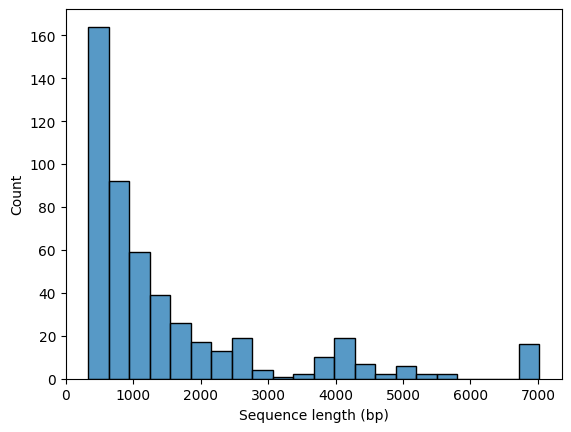

In [6]:
#@title 2.3) SELECT SEED LENGTH CUTOFF

from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt

#@markdown _Full length seed copies will be the most useful for generating the full length consensus sequence. Thus, one may want to exclude smaller seeds from the `.stk` file._

#@markdown _The command below creates a histogram of seed lengths from the `.stk` file, which can be used to help select a length cutoff_

#@markdown - Specify the name of the `.stk` file that contains the seed alignment generated in Step 2.2 (_e.g._ `Drosophila_melanogaster_rnd-3_family-103.stk`).
infile="Drosophila_melanogaster_TIR_1.stk" #@param {type:"string"}

lengths = []
for record in SeqIO.parse(infile, 'stockholm'):
  bps = len(record.seq.replace("-",""))
  lengths.append(bps)

ax = sns.histplot(data=lengths)
ax.set(xlabel='Sequence length (bp)')
plt.show()

In [12]:
#@title 2.4) FILTER SEED ALIGNMENT BY LENGTH

from Bio import SeqIO

#@markdown - Exclude sequences shorter than this length (_e.g._ `1500`). Set to `0` to select the `X` longest sequences where `X` = `max_sequences` below
length_cutoff = 6000 #@param {type:"integer"}
#@markdown - Maximum number of sequences to keep (_e.g._ `50`).
max_sequences = 50 #@param {type:"integer"}
#@markdown - Name of the _Stockholm_ file that contains the seed alignments (_e.g._ `Drosophila_melanogaster_rnd-3_family-103.stk`).
infile="Drosophila_melanogaster_TIR_1.stk" #@param {type:"string"}
#@markdown - Output filename for new seed alignment (_e.g._ `Drosophila_melanogaster_rnd-3_family-103.filtered.stk`).
outfile = "Drosophila_melanogaster_TIR_1.filtered.stk" #@param {type:"string"}

count=0
all=[]
d={}
s={}
for rec in SeqIO.parse(infile, 'stockholm'):
  bps = len(rec.seq.replace("-",""))
  d[rec.id]=bps
  s[rec.id]=rec

ds=sorted(d.items(), key=lambda x:x[1], reverse=True)
ds=dict(ds)
for recID in ds:
  if count < max_sequences and d[recID] >= length_cutoff:
    all.append(s[recID])
    count+=1

out=open(outfile,"w")
SeqIO.write(all,out,"stockholm")
out.close()

print("Retained",count,"sequences in",outfile)

Retained 16 sequences in Drosophila_melanogaster_TIR_1.filtered.stk


In [16]:
#@title 2.5) EXTEND TE SEED COPIES
#@markdown _Add flanking genome sequence to both ends of each TE copy in the length-filtered seed alignment. Extending TE copies ensures that the final consensus will represent the full length TE_
from Bio import AlignIO, SeqIO

#@markdown - Specify the amount of nucleotide flanking sequence to add to each end (_e.g._ left and right flanks) of each seed. As a starting point, we suggest adding 200 nucleotides to each flank.
left_flank = 400 #@param {type:"integer"}
right_flank = 400 #@param {type:"integer"}
#@markdown - Name of genome assembly fasta file (_e.g._ `dmel.fasta`).
genome = "dmel.fasta" #@param {type:"string"}
#@markdown - Name of the filtered seed alignment file from _Step 2.4_ (_e.g._ `Drosophila_melanogaster_rnd-3_family-103.filtered.stk`).
infile="Drosophila_melanogaster_TIR_1.filtered.stk" #@param {type:"string"}
#@markdown - Output seed filename in FASTA format with flanking sequence added (_e.g._ `copia_elements.fa`).
outfile="297_elements.fa" #@param {type:"string"}

d={}

for record in SeqIO.parse(genome,"fasta"):
  d[record.id] = record

fh=open(outfile,"w")
a = AlignIO.read(infile,"stockholm")
for record in a:
  RC = 0
  seqstr = record.seq.replace("-","")
  contig,coords = record.id.split(":")
  start,stop = coords.split("-")
  start = int(start)
  stop = int(stop)
  if start > stop:
    (start,stop) = (stop,start) #switch values
    start= start - right_flank - 1 # assume RepeatMasker coordinates are 1-based
    stop = stop  + left_flank
    RC = 1
  else:
    start= start - left_flank - 1 # assume RepeatMasker coordinates are 1-based
    stop = stop  + right_flank
  refRecord = d[contig]
  if start<0:
    start=0
  if stop>len(refRecord):
    stop=len(refRecord)
  if RC == 1:
    element = str(refRecord[start:stop].reverse_complement().seq.upper())
    outID = contig + ":" + str(stop) + "-" + str(start)
  else:
    element = str(refRecord[start:stop].seq.upper())
    outID = contig + ":" + str(start) + "-" + str(stop)
  fh.write(">" + outID + "\n" + element + "\n")
#  SeqIO.write(element,fh,"fasta")
fh.close()
#print("Extended left flank by",left_flank + "bp","and right flank by",right_flank + "bp")
print("Extended left flank by",left_flank, "bp","and right flank by",right_flank, "bp")
print("Output saved in",outfile)


Extended left flank by 400 bp and right flank by 400 bp
Output saved in 297_elements.fa


# **PART 3. ALIGN AND EXTEND TE COPIES**

_The TE seeds need to be extended until they include the entire length of the TE. The TE edges (i.e. the beginning and end of the TE) can be inferred by aligning the TE seeds and then plotting the conservation of each alignment column._

_Starting from the left side of the plot, the point where the conservation score jumps from ~25% to above ~50% (closer to 100% for active TE families) marks the beginning of the TE. The conservation score should remain relatively high for the full length of the TE, although short decreases are possible. The end of the TE is denoted by the point where the conservation score drops back down to ~25%._

>_Note: if the conservation score is high across the entire alignment, this means that the seeds have not been extended far enough and additional extension is needed to reach the beginning and/or end of the TE (see Step 3.3)._

In [17]:
#@title 3.1) GENERATE SEED ALIGNMENT FROM EXTENDED COPIES

#@markdown - Filename for the extended seed sequences from _Step 2.5_ above (_e.g._ `copia_elements.fa`).
infile = "297_elements.fa" #@param {type:"string"}
#@markdown - Name of the alignment output file (_e.g._ `copia_elements_aligned.fa`).
outfile = "297_elements_aligned.fa" #@param {type:"string"}

#@markdown >_Note: This can take 30 minutes or more depending on the amount of flanking sequence added to the seeds._


!mafft --localpair --maxiterate 1000 --preservecase $infile > $outfile

inputfile = orig
16 x 7820 - 7765 d
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
All-to-all alignment.
tbfast-pair (nuc) Version 7.526
alg=L, model=DNA200 (2), 2.00 (6.00), -0.10 (-0.30), noshift, amax=0.0
0 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 16
done.

Progressive alignment ... 
STEP     1 /15 
Reallocating..done. *alloclen = 16740
STEP    15 /15 
done.
tbfast (nuc) Version 7.526
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
generating a scoring matrix for nucleotide (

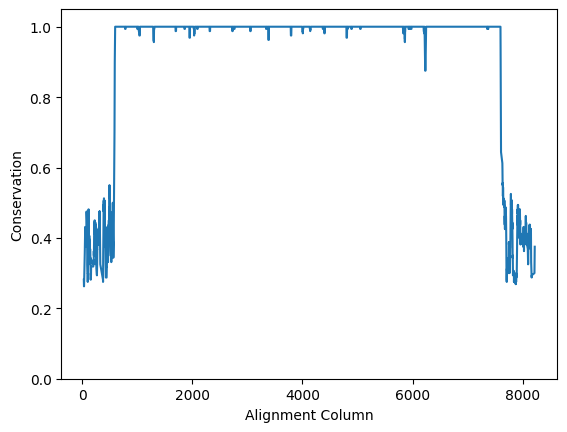

In [18]:
#@title 3.2) VISUALIZE ALIGNMENT CONSERVATION
#@markdown This cell plots the conservation score of each column of the seed alignment. A conservation score close to 1.0 reflects high sequence similarity at that position, indicating that those columns are part of the TE. A low conservation score (~0.25 or lower) corresponds to genomic regions that are no longer homologous (_i.e._ not part of the TE).
#@markdown
#@markdown When the seed sequences have been extended enough to include the full length TE, the plot will show a contiguous region of highly conserved sequence flanked by regions of low sequence conservation on both ends.
#@markdown
#@markdown If the plot shows highly conserved sequence on one or both edges, additional extension is needed. In this case follow _Step 3.3_ below.

#@markdown - Name of the alignment file from _Step 3.1_ (_e.g._ `copia_elements_aligned.fa`).
infile = "297_elements_aligned.fa" #@param {type:"string"}

from Bio import AlignIO
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np

align = AlignIO.read(infile,"fasta")
alen=len(align[0])
slen=len(align[:,0])
cons=[]
data=[]
for i in range(alen):
  col = align[:,i]
  counts = Counter(col)
  if "-" in counts:
    if counts["-"]/slen >= 0.5:
      continue
    else:
      del counts["-"]
  order=sorted(counts.items(), key=lambda x:x[1],reverse=True)
  score=order[0][1]/len(col)
  data.append([i,score])

d=pd.DataFrame(data=data,columns=["Alignment Column","Conservation"])
d['rolling_avg'] = d['Conservation'].rolling(window=10).mean()
ax=sns.lineplot(data=d,x="Alignment Column",y="rolling_avg")
ax.set(xlabel="Alignment Column",ylabel="Conservation")
ax.set_ylim(0, 1.05);

### 3.3) OPTIONAL: ADDITIONAL EXTENSION OF SEED SEQUENCES

_Follow the steps below if the conservation plot suggests that the TE seeds need to be extended further._

1. Return to _Step 2.5_ and increase one or both flanks, depending on what the conservation plot shows. We suggest doubling the increment of flanking sequence you are adding each time (_i.e._ 200, 400, 800, 1600, ...) If the flank of one end of the TE becomes apparent in the plot, it is only necessary to extend the other flank.
2. Rerun _Steps 3.1 & 3.2_
3. Repeat until the conservation plot shows flanks of low conservation on both ends

_Note: It is not necessary to modify the filenames for each iteration of extension._

---

### **Checkpoint:** Back Up Your Alignment File After Extension Is Complete

You’ve now completed the **iterative extension and alignment process**. Before continuing to **Part 4**, we recommend that you **back up** your final extended alignment file (`.fa`) to `MyDrive/TE_curation_files/extended_alignments` by **running the cell below if you linked your Google Drive**. This will prevent you from having to repeat these steps if your session times out due to inactivity or if you plan to pause and resume the curation workflow later.

If you **did not link Google Drive, you’ll need to download the file manually**.

To resume later:  
1. Rerun the **setup and installation** steps in a new Colab session  
2. **Copy** your saved extended alignment file from Google Drive in Step 1.1  
3. Continue with **Part 4** of the pipeline

In [19]:
final_alignment="297_elements_aligned.fa" #@param {type:"string"}
! if [ -d /content/drive/MyDrive ]; then \
      cp "$final_alignment" /content/drive/MyDrive/TE_curation_files/extended_alignments/. && \
      echo "Saved to Google Drive: MyDrive/TE_curation_files/extended_alignments/$final_alignment"; \
   else \
      echo "Google Drive NOT detected. Please download your extended alignment manually."; \
   fi

Saved to Google Drive: MyDrive/TE_curation_files/extended_alignments/297_elements_aligned.fa


---

# **PART 4. PRECISE IDENTIFICATION OF TE BOUNDARIES**

In [20]:
#@title 4.1) VISUALIZE SEED ALIGNMENT TO IDENTIFY THE EDGES OF THE TE

#@markdown This cell generates an interactive alignment visualization tool.
#@markdown After running the cell, use the settings dropdown menu to adjust the following parameters:
#@markdown ```
#@markdown color scheme: clustalx_dna   ← you can switch to a different scheme if you prefer
#@markdown row height: 8                ← increase/decrease to zoom in/out vertically
#@markdown column width: 8              ← increase/decrease to zoom in/out horizontally
#@markdown ```
#@markdown >_Note: hovering your mouse over the column will interactively identify its position in the alignment, which is necessary for specifying the TE edges in the following steps._

#@markdown - Specify the name of the seed alignment file from _Step 3.1_ (_e.g._ `copia_elements_aligned.fa`).
alignment = "297_elements_aligned.fa" #@param {type:"string"}

import IPython
from IPython.display import display, Javascript
from IPython.core.display import display, HTML

# paste file path below
drive_file_path = '/content/'+alignment

drive_file = open(drive_file_path)
file_content = drive_file.read()


# convert the Python variable 'file_content' into a JavaScript variable 'fastaContent',
# create a Blob of MIME type 'application/fasta' with the file data,
# and generate a URL for the Blob and make it globally accessible
html_code = f'''
<html>
  <head>
    <script>
        var fastaContent = {repr(file_content)};
        var blob = new Blob([fastaContent], {{ type: 'application/fasta' }});
        var blob_url = window.URL.createObjectURL(blob);
      </script>
  </head>
  <body>
  </body>
</html>
'''


#run MSAviewer script using model with file handle attribute that points to blob url variable
html_code2 = '''
<html>
  <head>
    <script>
      window.global = window
    </script>
    <script
      crossorigin
      src="https://unpkg.com/react@17/umd/react.development.js"
    ></script>
    <script
      crossorigin
      src="https://unpkg.com/react-dom@17/umd/react-dom.development.js"
    ></script>
    <script
      crossorigin
      src="https://unpkg.com/react-msaview@2.1.5/bundle/index.js"
    ></script>
  </head>
  <body>
    <div id="root" />
    <script>

      const { MSAView, MSAModel } = window.ReactMSAView
      const model = MSAModel.create({
        id: `${Math.random()}`,
        type: "MsaView",
        msaFilehandle: {uri: blob_url}
        });

      model.setWidth(1800)

      ReactDOM.render(
        React.createElement(MSAView, { model }),
        document.getElementById('root'),
      )

    </script>
  </body>
</html>
'''

#runs html code from strings
display(HTML(html_code))
display(HTML(html_code2))

To find the TE edges, scroll through the alignment to the point where the sequences become clearly alignable. This point represents the beginning of the TE. If you have difficulty finding this region, we recommend zooming out by reducing the `row height` and `column height` parameters in the settings dropdown menu, as described above.
>_Note: the TE edges may or may not be clearly defined, depending on the properties of the TE family being investigated. The goal here is to identify a range of alignment columns that contain the TE boundary, for both the left and right edges of the TE. Use a lenient range to be sure that the true TE edge is included within each span. The Target Site Duplication step below will help refine the edges. If the alignment does not show ambiguous/unalignable sequence on both ends, further extension of seed sequences is needed. Return to Step 3.3 in this case._

Record the column numbers that span the beginning of the TE, where the sequences start to align. The first column in the range should lie within the unaligned sequence >= 20 nucleotides before the beginning of the TE. The second column should lie 5-10 nucleotides after the beginning of the TE. This range will be used for the `left_start` and `left_end` parameters in the trimming step below.

Continue scrolling through the aligned sequences until reaching the end of the TE, where the sequences are no longer clearly aligned to one another. Record the column numbers that span the end of the TE. The first column in the range should lie within the aligned sequence, 5-10 nucleotides before the point where the sequences are no longer aligned. The second column should lie >=20 nucleotides after the end of the TE. This range will be used for the `right_start` and `right_end` parameters in the trimming step below.



In [21]:
#@title 4.2) SEARCH FOR TARGET SITE DUPLICATIONS (TSDs)
#@markdown Running this cell removes the internal portion of the seed alignment to allow visualization (in _Step 4.3_, below) of just the left and right TE edges, separated by `XXX`
#@markdown
#@markdown - Specify the range of columns for the left edge of the TE, as explained in _Step 4.1_ above.
left_start = 569 #@param {type:"integer"}
left_end = 595 #@param {type:"integer"}
#@markdown - Specify the range of columns for the right edge of the TE, as explained in _Step 4.1_ above.
right_start = 7590 #@param {type:"integer"}
right_end = 7617 #@param {type:"integer"}
#@markdown - Specify the filename of the seed alignment from _Step 3.1_ (_e.g._ `copia_elements_aligned.fa`).
alignFile = "297_elements_aligned.fa" #@param {type:"string"}
#@markdown - Specify an output filename for the internally-trimmed alignment that includes only the ranges specified above (_e.g._ `alignment_ends.fa`).
outfile="alignment_ends.fa" #@param {type:"string"}

from Bio import AlignIO
# user gives a start/end range of columns for both the beginning and end of the TE
#left_start=371
#left_end=377
#right_start=5182
#right_end=5197

# convert to bed-style numbering
left_start-=1
right_start-=1

#alignFile="LINE_CR1_elements_aligned.fa"
#outfile="alignment_ends.fa"

TSD_flank = 20 # number of extra flanking columns to include to search for TSD
internal_flank = 5 # number of extra columns to include internal to TE
spacer="XXX" # left and right ends of TE will be separated by this spacer sequence

leftside_trim_start = left_start-TSD_flank
leftside_trim_stop  = left_end+internal_flank
rightside_trim_start= right_start-internal_flank
rightside_trim_stop = right_end+TSD_flank

align=AlignIO.read(alignFile,"fasta")
left =align[:,leftside_trim_start:leftside_trim_stop]
right=align[:,rightside_trim_start:rightside_trim_stop]

out=open("temp.fa","w")
for record in align:
  out.write(">" + record.id + "\n")
  out.write(spacer + "\n")
out.close()

center=AlignIO.read("temp.fa","fasta")
out2=open(outfile,"w")
newalign = left + center + right
AlignIO.write(newalign,out2,"fasta")
out2.close()
print("Internally trimmed alignment written to:",outfile)

Internally trimmed alignment written to: alignment_ends.fa


In [22]:
#@title 4.3) SEARCH FOR TARGET SITE DUPLICATIONS (TSDs) & IDENTIFY EXACT TE EDGES

#@markdown This cell visualizes the internally trimmed alignment from _Step 4.2_, which makes it easier to identify TSDs
#@markdown
#@markdown Some TEs are flanked by a constant-length TSD as a result of their integration mechanism.
#@markdown Examine the alignment to search for repeated sequences that appear just before, and just after, the TE edges. In the example below, a 5bp TSD is shown for a TE represented by the string of `T's`.
#@markdown >_Note: Target site duplications directly flank the beginning and end of a TE but are NOT part of the TE._
#@markdown
#@markdown ```
#@markdown ...AGCGATTTTTTTTTTTTTTTTTTTTAGCGA...
#@markdown ...CGTTATTTTTTTTTTTTTTTTTTTTCGTTA...
#@markdown ...ATCAGTTTTTTTTTTTTTTTTTTTTATCAG...
#@markdown ...GGCATTTTTTTTTTTTTTTTTTTTTGGCAT...
#@markdown ```

#@markdown >_Most TSDs range from 2 to 20 basepairs in size. The sequence that is duplicated will be unique for each TE copy (i.e. alignment row) but the duplication length should be consistant across rows. Note that some TE families do not create TSDs at all._

#@markdown If you find a TSD, use its location to help define the exact columns where the TE starts and ends.
#@markdown If you cannot find a TSD, base your estimate on the first and last columns of the TE that show unambiguous alignment and good conservation.

#@markdown - Name of the internally-trimmed alignment file from _Step 4.2_ (_e.g._ `alignment_ends.fa`).
alignment = "alignment_ends.fa" #@param {type:"string"}

import IPython
from IPython.display import display, Javascript
from IPython.core.display import display, HTML

# paste file path below
drive_file_path = '/content/'+alignment

drive_file = open(drive_file_path)
file_content = drive_file.read()


# convert the Python variable 'file_content' into a JavaScript variable 'fastaContent',
# create a Blob of MIME type 'application/fasta' with the file data,
# and generate a URL for the Blob and make it globally accessible
html_code = f'''
<html>
  <head>
    <script>
        var fastaContent = {repr(file_content)};
        var blob = new Blob([fastaContent], {{ type: 'application/fasta' }});
        var blob_url = window.URL.createObjectURL(blob);
      </script>
  </head>
  <body>
  </body>
</html>
'''


#run MSAviewer script using model with file handle attribute that points to blob url variable
html_code2 = '''
<html>
  <head>
    <script>
      window.global = window
    </script>
    <script
      crossorigin
      src="https://unpkg.com/react@17/umd/react.development.js"
    ></script>
    <script
      crossorigin
      src="https://unpkg.com/react-dom@17/umd/react-dom.development.js"
    ></script>
    <script
      crossorigin
      src="https://unpkg.com/react-msaview@2.1.5/bundle/index.js"
    ></script>
  </head>
  <body>
    <div id="root" />
    <script>

      const { MSAView, MSAModel } = window.ReactMSAView
      const model = MSAModel.create({
        id: `${Math.random()}`,
        type: "MsaView",
        msaFilehandle: {uri: blob_url}
        });

      model.setWidth(1800)

      ReactDOM.render(
        React.createElement(MSAView, { model }),
        document.getElementById('root'),
      )

    </script>
  </body>
</html>
'''

#runs html code from strings
display(HTML(html_code))
display(HTML(html_code2))

In [23]:
#@title 4.4) FINAL SEED ALIGNMENT TRIM
#@markdown Provide the numbers for the exact start and end columns that encompass the complete TE in the seed alignment.
#@markdown >_NOTE: Column numbers should be from the internally-trimmed (i.e. XXX-containing) alignment visualized in Step 4.3._

#@markdown - Enter the column where the TE starts
beg = 45 #@param {type:"integer"}
#@markdown - Enter the column where the TE ends
end = 64 #@param {type:"integer"}
#@markdown - Filename for the final trimmed alignment
outfile = "final_trimmed.fasta" #@param {type:"string"}

beg-=1
leftsidelen  = leftside_trim_stop  - leftside_trim_start
rightsidelen  = rightside_trim_stop - rightside_trim_start
overhang = (rightsidelen + leftsidelen + len(spacer)) - end

final_start = leftside_trim_start + beg
final_end   = rightside_trim_stop - overhang

print(final_start,final_end)
outf=open(outfile,"w")
AlignIO.write(align[:,final_start:final_end],outf,"fasta")
outf.close()

592 7593


In [24]:
#@title 4.5) CLEAN SEED ALIGNMENT TO REMOVE GAPPY REGIONS
#@markdown Individual TE copies can acquire sequence insertions that result in gaps being added to all other sequences in the alignment.
#@markdown This step removes inserted sequences that are present in less than a specified fraction of the TE copies in the seed alignment.

#@markdown - Filename of the trimmed alignment from _Step 4.4_ above (_e.g._ `final_trimmed.fasta`).
infile = "final_trimmed.fasta" #@param {type:"string"}
#@markdown - Output filename for the cleaned alignment (_e.g._ `final_trimmed_cleaned.fasta`).
outfile = "final_trimmed_cleaned.fasta" #@param {type:"string"}
#@markdown - Desired gap threshold (recommended default is **0.5**)
gap_threshold = 0.5 #@param {type:"number"}
#@markdown
#@markdown - **Gap threshold** controls which gap-containing columns are removed from the alignment.
#@markdown   - A **value of 0.5** (recommended) removes columns with gaps present in **≥50%** of TE copies.
#@markdown   - Setting it **higher (e.g. 0.7)** will remove **more** gap-containing columns (_i.e._ all columns with gaps present in ≥30% of sequences).
#@markdown   - Setting it **lower (e.g. 0.3)** will remove **fewer** gap-containing columns (_i.e._ only columns with gaps present in ≥70% of sequences).
#@markdown


!trimal -in $infile -out $outfile -gt $gap_threshold
!echo Cleaned alignment written to $outfile

Cleaned alignment written to final_trimmed_cleaned.fasta


# **PART 5. GENERATE FINAL FILES**

In [25]:
#@title 5.1) FINAL CONSENSUS SEQUENCE
#@markdown This step creates a single consensus sequence in FASTA format from the cleaned seed alignment.
#@markdown - Filename of the cleaned alignment from _Step 4.5_ (_e.g._ `final_trimmed_cleaned.fasta`).
infile = "final_trimmed_cleaned.fasta" #@param {type:"string"}
#@markdown - Output filename for the consensus sequence (_e.g._ `copia_consensus.fasta`).
outfile = "297_consensus.fasta" #@param {type:"string"}

!piler -cons $infile -out $outfile -label final_consensus

   0 s       1 Mb (  0%) Reading alignment
   0 s       1 Mb (  0%) Reading alignment done (0 s).
16 seqs, length 6996


In [26]:
#@title 5.2) RECLASSIFY FINAL CONSENSUS SEQUENCE
#@markdown Improving/refining the TE consensus sequence may improve our ability to classify it.
#@markdown This step runs the program `RepeatClassifier` to check if the classification of the consensus sequence changes.
#@markdown The output will be provided as a `.classified` file (_e.g._ `copia_consensus.fasta.classified`).

#@markdown This output file is in FASTA format and contains the same DNA sequence as in the input file, however the ID is modified to reflect the classification and the sequence is reverse complemented if it matches known TE sequences on the minus strand.

#@markdown - Input filename for the updated consensus sequence file from _Step 5.1_ (_e.g._ `copia_consensus.fasta`).
consensus_file = "297_consensus.fasta" #@param {type:"string"}
updated_file   = consensus_file + ".classified"

!RepeatClassifier -consensi $consensus_file
!echo ======================================
!echo Classification complete. Results:
!grep ">" $consensus_file\.classified

from Bio import SeqIO
original = SeqIO.read(consensus_file,"fasta")
updated  = SeqIO.read(updated_file,"fasta")
o_str = str(original.seq)
u_str = str(updated.seq)
u_rc  = str(updated.seq.reverse_complement())

if o_str == u_str:
  print("\n\nIMPORTANT: RepeatClassifier detected that your consensus sequence is in the correct orientation and it was not reverse-complemented.")
elif o_str == u_rc:
  print("\n\nIMPORTANT: RepeatClassifier detected that your consensus sequence is in the reverse orientation and has therefore reverse-complemented it.")
  print("The reclassified and reverse complemented version of your consensus sequence is in the file '" + updated_file + "'.")



RepeatClassifier Version 2.0.5
  - Looking for Simple and Low Complexity sequences..
  - Looking for similarity to known repeat proteins..
  - Looking for similarity to known repeat consensi..
Classification complete. Results:
>final_consensus#LTR/Gypsy 


IMPORTANT: RepeatClassifier detected that your consensus sequence is in the correct orientation and it was not reverse-complemented.


In [27]:
#@title 5.3) FINAL FILES: SEED ALIGNMENT (STK) AND CONSENSUS (FASTA)
#@markdown This cell will save your trimmed seed alignment, along with metadata describing your TE, in the Stockholm format.
#@markdown The consensus sequence from _Step 5.2_ will also be renamed to reflect the family name specified below.
#@markdown These two files can be deposited in the DFAM database.

from Bio import AlignIO
from Bio import SeqIO
import os
import shutil
# these need to be input by user
#@markdown - TE family name in _RepBase_ format: `Superfamily-Number_genusSpecies` (_e.g._ `Copia-1_dMel`).
family_name = "297-1_dMel" #@param {type:"string"}
#@markdown - Short description of the TE (_e.g._ `LTR retrotransposon with 5 bp TSD`).
description = "LTR retrotransposon with 4 bp TSD" #@param {type:"string"}
#@markdown - Replace `Doe J` below with your Lastname and First Initial(s)
authors = "Doe J" #@param {type:"string"}
#@markdown - TE classification in [DFAM format](https://dfam.org/classification/tree) (_e.g._ `Interspersed_Repeat;Transposable_Element;Class_I_Retrotransposition;Retrotransposon;Long_Terminal_Repeat_Element;Ty1-Copia`).
classification = "Interspersed_Repeat;Transposable_Element;Class_I_Retrotransposition;Retrotransposon;Long_Terminal_Repeat_Element;Gypsy-ERV;Gypsy" #@param {type:"string"}
#@markdown - Genus of TE host (_e.g._ _Drosophila_).
genus = "Drosophila" #@param {type:"string"}
#@markdown - Species of TE host (_e.g._ _melanogaster_).
species = "melanogaster" #@param {type:"string"}
#@markdown - Genome assembly accession/version (_e.g._ `dm6`).
assembly = "dm6" #@param {type:"string"}
#@markdown - Final trimmed alignment output from _Step 4.5_ (_e.g._ `final_trimmed_cleaned.fasta`).
trimmed_alignment = "final_trimmed_cleaned.fasta" #@param {type:"string"}
#@markdown - Classified consensus from _Step 5.2_ (_e.g._ `copia_consensus.fasta.classified`).
consensus = "297_consensus.fasta.classified" #@param {type:"string"}

outfile = family_name + ".stk"
outfile2= family_name + ".fasta"

align = AlignIO.read(trimmed_alignment,"fasta")
num_sp = len(align)
seed_source = "Curated"
out=open(outfile,"w")
out.write("# STOCKHOLM 1.0\n")
out.write("#=GF ID\t"+family_name+"\n")
out.write("#=GF DE\t"+description+"\n")
out.write("#=GF AU\t"+authors+"\n")
out.write("#=GF SE\tCurated\n")
out.write("#=GF TP\t"+classification+"\n")
out.write("#=GF OC\t"+genus+"\n")
out.write("#=GF OC\t"+species+"\n")
out.write("#=GF SQ\t"+str(num_sp)+"\n")


for record in align:
  out.write(assembly + ":" + record.id + "\t" + str(record.seq) + "\n")
out.write("//\n")
out.close()

s = SeqIO.read(consensus,"fasta")
out = open(outfile2,"w")
out.write(">" + family_name + "\n")
out.write(str(s.seq) + "\n")
out.close()

print("Final annotated seed alignment written to:",outfile)
print("Final renamed consensus sequence written to:",outfile2)

drive_dir = "/content/drive/MyDrive/TE_curation_files/curated_families"
if os.path.isdir(drive_dir):
    for f in (outfile, outfile2):
        shutil.copy2(f, drive_dir)
    print(f"Saved both files to Google Drive: MyDrive/TE_curation_files/curated_families/")
else:
    print("Google Drive NOT detected.")
    print("   Please download both files manually.")


Final annotated seed alignment written to: 297-1_dMel.stk
Final renamed consensus sequence written to: 297-1_dMel.fasta
Saved both files to Google Drive: MyDrive/TE_curation_files/curated_families/


# **PART 6. TE SEQUENCE ANALYSIS**

Draw a non-overlapping wordmatch dotplot of two sequences
Created dotpath.1.png


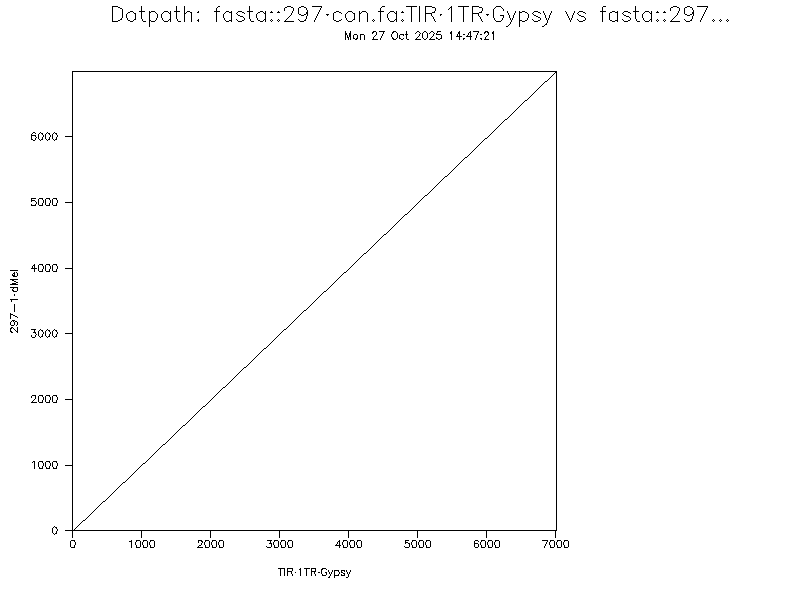

In [28]:
#@title 6.1) COMPARE THE ORIGINAL AND UPDATED CONSENSUS SEQUENCES
#@markdown A dotplot shows where two sequences align.
#@markdown The amount by which the updated consensus was extended can be inferred based on where the original and updated consensus sequences align to each other.

#@markdown - Filename of the original consensus sequence from _Step 2.1_ (_e.g._ `copia_con.fa`).
original_consensus = "297_con.fa" #@param {type:"string"}
#@markdown - Filename of the final consensus sequence from _Step 5.3_ (_e.g._ `Copia-1_dMel.fasta`).
updated_consensus = "297-1_dMel.fasta" #@param {type:"string"}
#@markdown - Sequence similarity window size (as a default we recommend setting this to `10`).
window_size = 10 #@param {type:"integer"}
#@markdown - Enter `True` below if _RepeatClassifier_ reverse-complemented the consensus sequence in Step 5.2 above. Otherwise leave as `False`. If set to `True`, the dotplot will display the updated consensus sequence in its original orientation, prior to running _RepeatClassifier_.
reverse_complemented = "False" #@param {type:"string"}
#!dotmatcher -windowsize $window_size -threshold 50 -graph png $original_consensus $updated_consensus
!dotpath -word $window_size -graph png $original_consensus -sreverse2 $reverse_complemented $updated_consensus

from IPython.display import Image
Image('dotpath.1.png')

query:                         297-1_dMel.fasta
ref genome:                    dmel.fasta
TE -> genome blastn e-value:   10e-8
full length min ratio:         0.9
hits transparency:             0.3
full length hits transparency: 0.9
RepeatPeps is downloaded and formatted, blastp-ing...
[1] "R: ploting genome blastn results and computing coverage..."
[1] "consensus length: 6996 bp"
[1] "R: ploting self dot-plot and orf/protein hits..."
null device 
          1 
Done! The graph (.pdf) can be found in the output folder: .


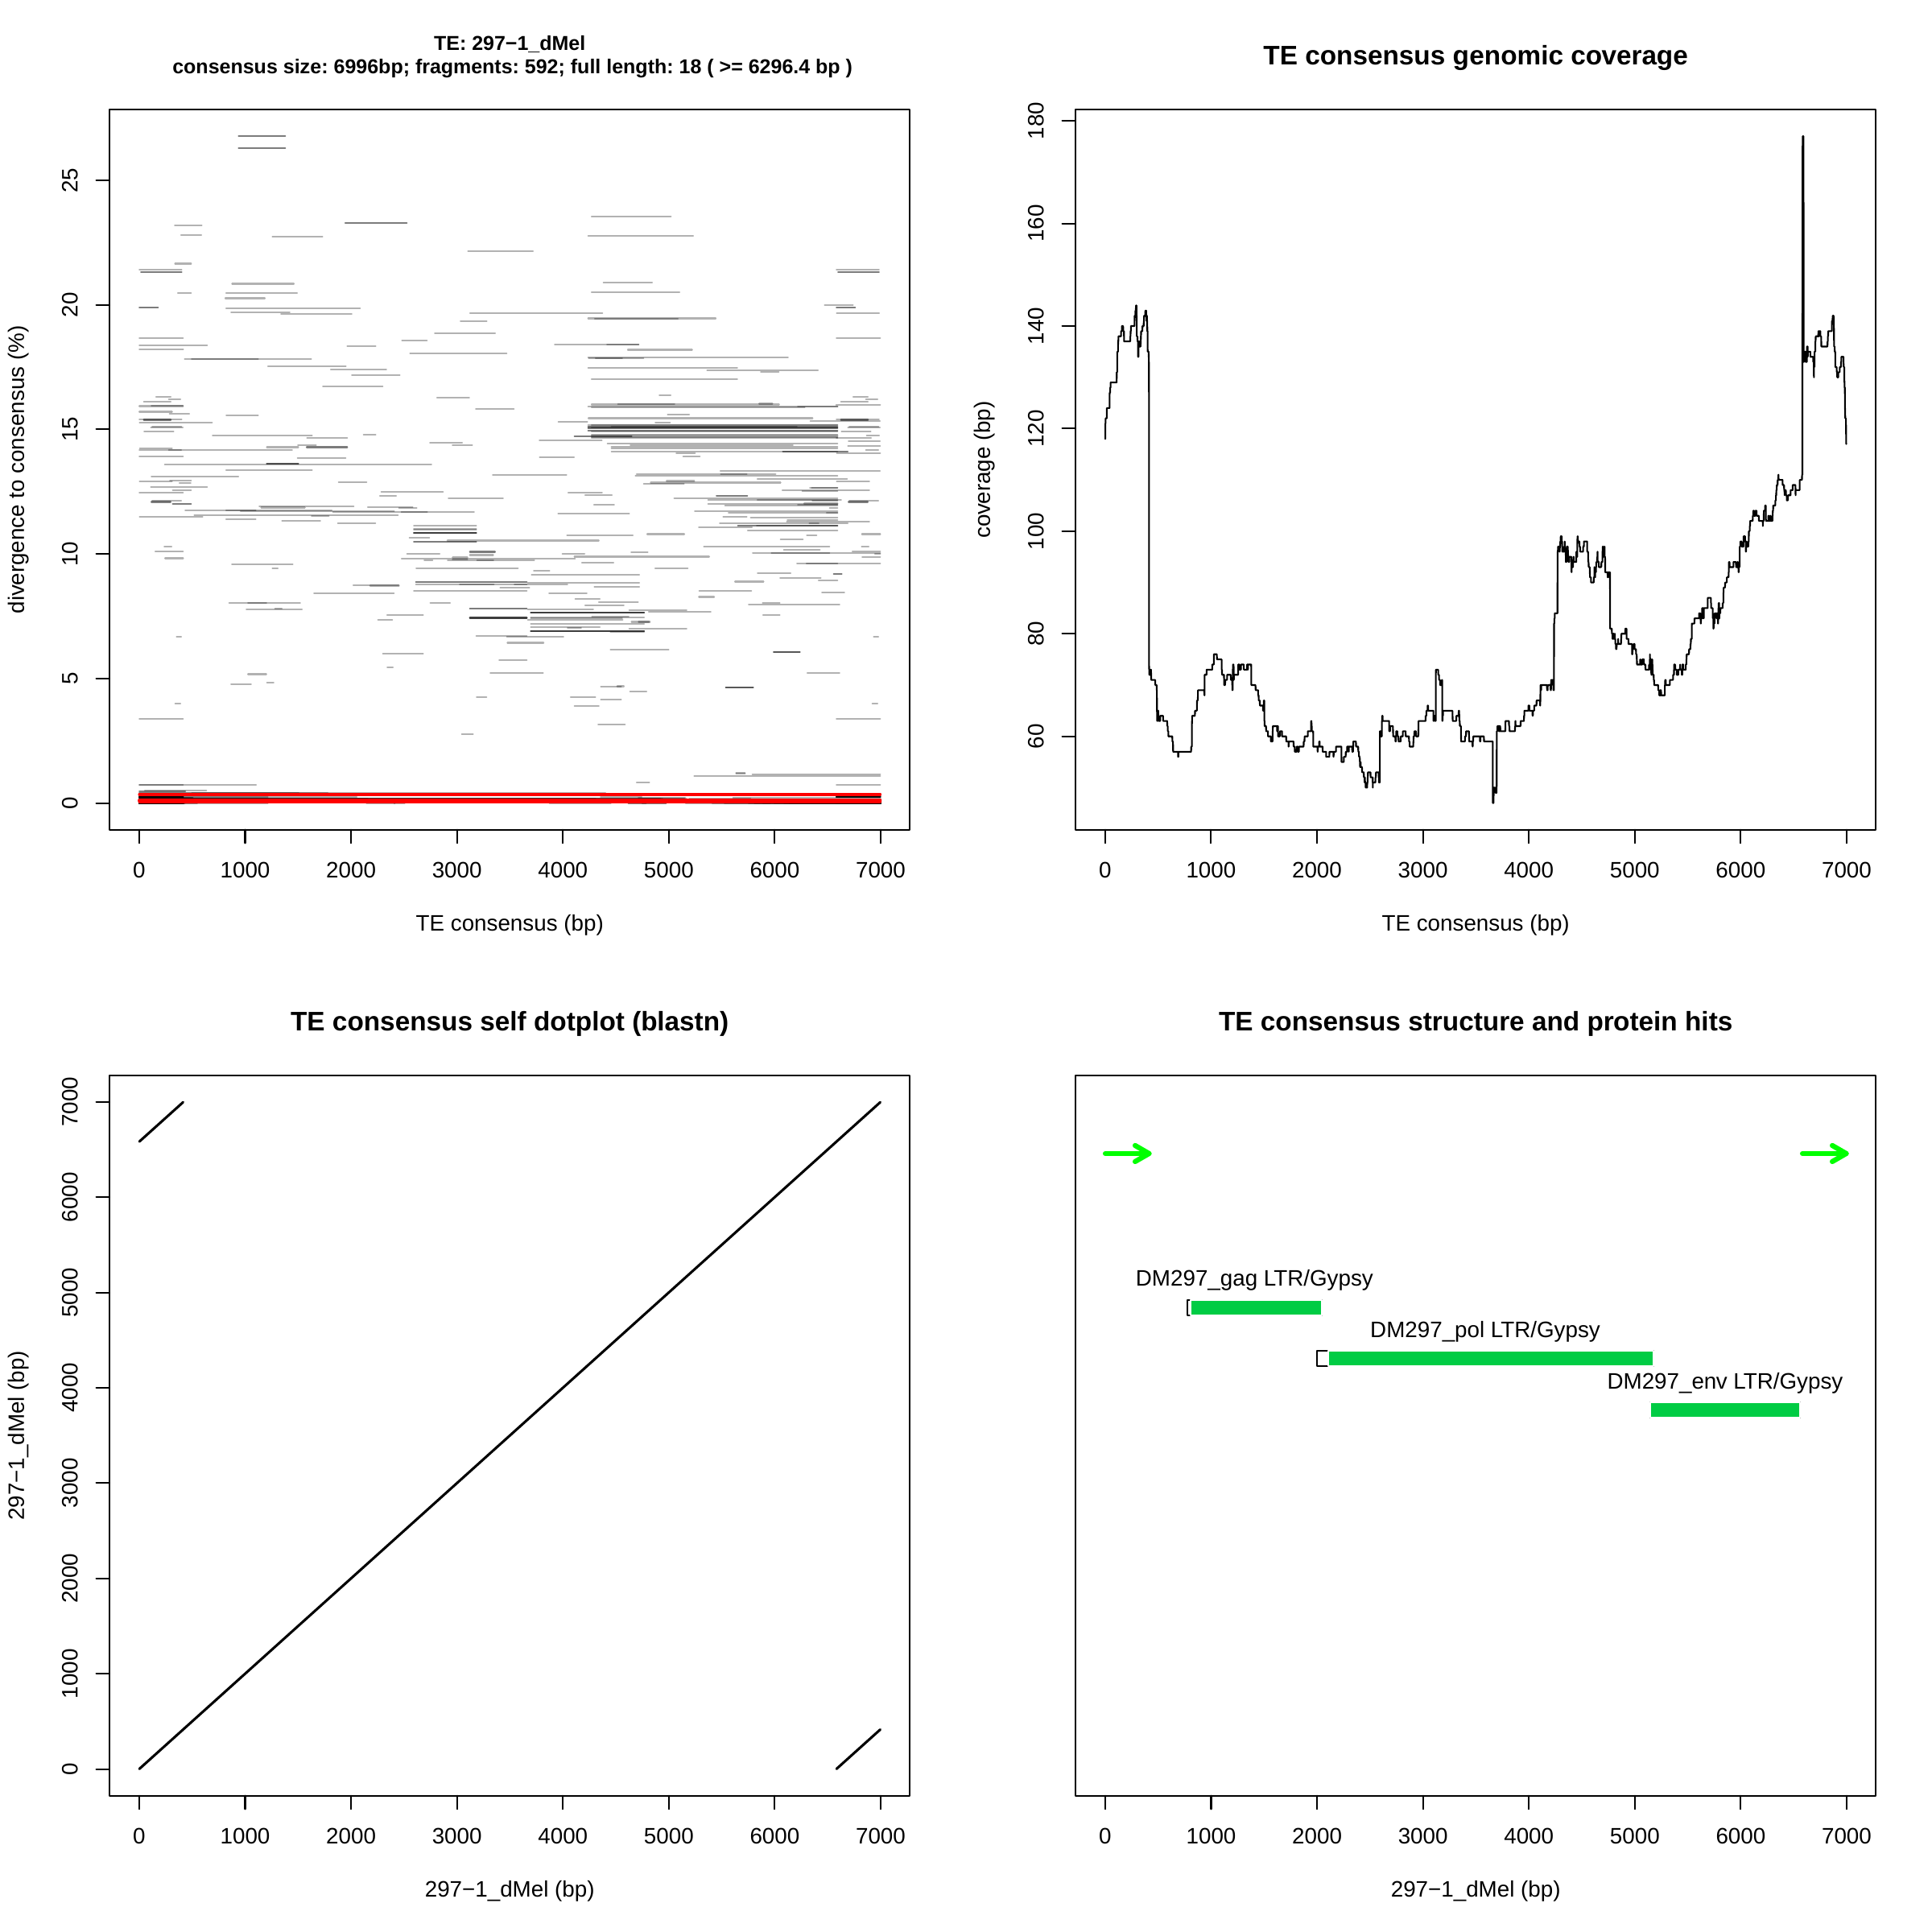

In [31]:
#@title 6.2) ANALYSIS OF CONSENSUS SEQUENCE WITH TE-AID

#@markdown [TE-AID](https://github.com/clemgoub/TE-Aid) produces four plots:
#@markdown 1. (top left)  Each horizontal line represents a single TE copy/fragment. The plot shows which part of the consensus sequence is covered by each copy and the sequence identity between them.
#@markdown 2. (top right) Genomic coverage of the consensus: TEs whose copies are frequently truncated will show differences in coverage across the consensus
#@markdown 3. (bottom left) Dotplot comparing the consensus to itself. This plot is useful for identifying structural features such as Long Terminal Repeats (LTRs) or Terminal Inverted Repeats (TIRs)
#@markdown 4. (bottom right) Structural and coding features including: TIR and LTR suggestions, open reading frames (ORFs) and TE protein hit annotations.

#@markdown - Filename of the final consensus sequence from _Step 5.3_ (_e.g._ `Copia-1_dMel.fasta`).
final_consensus = "297-1_dMel.fasta" #@param {type:"string"}
final_consensus_out=final_consensus+".c2g.pdf"
#@markdown - Filename for the genome assembly (_e.g._ `dmel.fasta`).
genome = "dmel.fasta" #@param {type:"string"}


!TE-Aid/TE-Aid -q $final_consensus -g $genome

from pdf2image import convert_from_path
pdf=final_consensus_out
images = convert_from_path(pdf)
images[0]

# **6.3) FINISHED - DOWNLOAD FINAL FILES**

#### You are finished curating this TE family.
- If you linked your Google Drive, make sure your final files (_e.g._ `Copia-1_dMel.stk` and `Copia-1_dMel.fasta`) are present in your Google Drive in the folder `MyDrive/TE_curation_files/curated_families`.
- If you did not link your Google Drive, you will need to download these files manually.
- Download a copy of this notebook for future reference: `File -> Download -> Download .ipynb`
- Rename the file so that it contains both the `seqID` from _Step 2.1_ and the `familyName` from _Step 5.3_.
- Download and rename the TE-Aid results PDF for future reference (`final_consensus.c2g.pdf`)

# **PART 7. APPENDIX**
Below are instructions for:
1. Using the Galaxy server to run _RepeatModeler2_
2. Using the Galaxy server to run _RepeatMasker_
3. Creation of a repeat landscape plot
4. Creation of an interactive repeat library summary table
5. Alternative _RepeatMasker_ approach for large-scale curation efforts
6. Alternative _RepeatMasker_ approach for extremely large genomes

>_If you do not already have a repeat library for your genome assembly and/or a TE family of interest for manual curation, you can follow Steps 7.1 - 7.4 to generate a de novo repeat library for your genome assembly and select a TE family of interest for manual curation._

>_If you are curating many TE families from the same genome, it is more time-efficient to use the approach detailed in Step 7.5_

>_If the RepeatMasker step exceeds the allowable runtime in the notebook, you can use Galaxy instead, which allows a longer runtime, as described in Step 7.6_

### 7.1) Running **RepeatModeler** on the Galaxy Server
_ColabCuraTE_ relies on a pre-existing **repeat library** as input, typically generated by _de novo_ TE discovery tools such as **RepeatModeler2**. Running such tools on a whole-genome assembly is extremely computationally intensive and thus not feasible within the Google Colab environment. Below we provide details on how to use the **Galaxy web server** as a complementary resource to run _RepeatModeler2_ for generating a repeat library.


We recommend running _**RepeatModeler2**_ on the [Galaxy Europe server](https://usegalaxy.eu), which allows for longer runtimes than other Galaxy servers.
#### Steps to Run _RepeatModeler2_ on Galaxy:
1. **Go to:** [https://usegalaxy.eu](https://usegalaxy.eu)
2. **Create an account** or log in (required to submit jobs and track progress).
3. Upload your genome FASTA file:
    - Click the upload icon (top left).
4. In the Galaxy Tools panel, search for **"RepeatModeler"** and select it.
5. Set the parameters:
    - **Input Genome**: Select your uploaded FASTA file.
    - Leave other settings as default unless you have specific options.
6. Click **Run Tool** and wait for the job to complete (runtime may take several days depending on genome size). You’ll be able to monitor progress in the history panel (right side).
7. Once complete, download the **RepeatModeler repeat library** file (usually named `RepeatModeler on data 1: consensus sequences`) for use as an input file in the _ColabCuraTE_ pipeline.

### 7.2) Running **RepeatMasker** on the Galaxy Server
Running RepeatMasker on large genomes or with large repeat libraries (e.g. a full RepeatModeler output) can exceed the runtime limits of this notebook. Instead, we recommend running RepeatMasker on the Galaxy Europe server: [https://usegalaxy.eu](https://usegalaxy.eu), which supports longer jobs and large datasets.
#### Follow These Steps:
1. **Sign in** to your account at [https://usegalaxy.eu](https://usegalaxy.eu). If you don’t have one, you’ll need to create one (it’s free).
2. **Upload your input files**:
    - A FASTA file of your organism’s genome.
    - A FASTA file of your repeat library (e.g., the file output by RepeatModeler in Step 7.1).
    - Use the **Upload Data** button (top left) and select the files from your computer. Upload time will vary based on file size.
3. After the files finish uploading, search for **RepeatMasker** in the **Tools** panel (top left), and click the tool when it appears.
4. Set the parameters as follows:
    - **Genomic DNA**: Select your uploaded genome FASTA file.
    - **Repeat library source**: Choose `Custom library of repeats`.
    - **Custom library of repeats**: Select the repeat library file you uploaded.
    - **Advanced options → Output alignments file**: Set this to `Yes` to generate the seed alignment file.
    - Leave other settings as default unless you have specific options.
    - (Optional) Under **Email notification**, you can choose to be notified when the job completes.
5. Click **Run Tool** to start the job. Note: This may take several hours or longer depending on your genome and repeat library size.
6. When the job finishes, your output files will appear in the **History** panel (right side). The file you need is labeled:#@markdown
    > `RepeatMasker alignment on data X and data Y`
7. Follow the instructions below to upload this file to the current Google Colab environment.


In [ ]:
#@markdown ### 7.2 cont'd) Upload **RepeatMasker** alignment file from the Galaxy Server

#@markdown If you processed data on [Galaxy Europe](https://usegalaxy.eu), you can download your output files directly into this Colab notebook:
#@markdown
#@markdown 1. In Galaxy, go to the **History panel** on the right.
#@markdown 2. Click the **History options icon** (three horizontal lines) → click **"Share & Manage Access"**.
#@markdown 3. Click **"Make History accessible"** and save.
#@markdown 4. To upload the RepeatMasker alignment file, click its filename in the Galaxy server to expand it (_i.e._ `Repeatmasker alignment on data X and data Y`), and then click the **"Share link"** button that looks like a paperclip. This will copy the file link.
#@markdown 5. Paste this link in the space below and run this cell to upload the file from Galaxy.


#@markdown - Specify the name of the link from Galaxy to the RepeatMasker alignment file (_e.g._ `https://usegalaxy.eu/api/datasets/26c75dcccb616ac84ceecc507717204f/display?to_ext=txt`).
galaxy_link="https://usegalaxy.eu/api/datasets/26c75dcccb616ac84ceecc507717204f/display?to_ext=txt" #@param {type:"string"}
#@markdown The RepeatMasker alignment file will be saved as `repeatmasker.align` in the `/content` directory here.

!wget -O repeatmasker.align $galaxy_link
#!mv display?to_ext=txt repeatmasker.align

In [ ]:
#@markdown ### 7.3) Run **RepeatMasker** scripts to generate input files for assessing repeat landscape of your genome
#@markdown This will generate a table summarizing the RepeatMasker output, from which you can select a TE family of interest to proceed with for curation. For instance, you may be interested in the most abundant TE families in this organism's genome. To do this, you would sort the table by `Total Basepairs in Genome`, which will rank TE families by their abundance.

#@markdown NOTE: This step may take ~30 minutes to run.


#@markdown - Edit this to specify the name of the genome fasta file (_e.g._ `dmel.fasta`).
genome="dmel.fasta" #@param {type:"string"}
genome_out=genome+".2bit"
#@markdown - Edit this to specify a name for the output `*.divsum` file that this step will create (_e.g._ `dMel.divsum`).
divsum_file="dMel.divsum" #@param {type:"string"}
#@markdown - Edit this to specify a name for the output `*.html` file that this step will create (_e.g._ `dMel.html`).
html_file="dMel.html" #@param {type:"string"}

!cd /content && ln -s /usr/local/share/RepeatMasker/*.pm .
!wget https://raw.githubusercontent.com/rmhubley/RepeatMasker/master/util/calcDivergenceFromAlign.pl
!chmod a+x calcDivergenceFromAlign.pl
!wget https://raw.githubusercontent.com/rmhubley/RepeatMasker/master/util/createRepeatLandscape.pl
!chmod a+x createRepeatLandscape.pl
!perl calcDivergenceFromAlign.pl -s $divsum_file repeatmasker.align
!faToTwoBit $genome $genome_out
!perl createRepeatLandscape.pl -div $divsum_file -twoBit $genome_out > $html_file
!rm *.pm *.pl

In [ ]:
#@title 7.3 cont'd) Create repeat landscape plot
#@markdown This will generate a graph summarizing the repeat landscape from your organism's genome.

#@markdown - Edit this to specify the filename for the `*.html` file that was output above (_e.g._ `dMel.html`).
html_file = "dMel.html" #@param {type:"string"}

import IPython
from IPython.display import display, Javascript
from IPython.core.display import display, HTML

display(HTML(html_file))

In [ ]:
#@title 7.4) Generate table summarizing **RepeatMasker** output
#@markdown This will generate a table summarizing the RepeatMasker output, from which you can select a TE family of interest for manual curation. For instance, you may be interested in the most abundant TE families in your organism's genome. To do this, you would sort the table by `Total Basepairs in Genome`, which will rank TE families by their abundance.

#@markdown - Specify the name of the `*.divsum` file output from the step above (_e.g._ `dMel.divsum`).
divsum_file="dMel.divsum" #@param {type:"string"}
#@markdown - The `index` column is the name of the TE (needed for `Step 2.1` in the curation notebook).

#@markdown - Each of the other columns can be sorted by clicking on the header.

#@markdown - The table rows can be filtered by clicking on the filter button.

from google.colab import data_table
data_table.enable_dataframe_formatter()
import pandas as pd
data={}

divsum=divsum_file
fh=open(divsum)
for i in range(6):
  fh.readline()
for line in fh:
  info=line.split()
  if len(info)<5:
    break
  if info[0] == "Simple_repeat":
    continue
  data[info[1]]={"TE Class":info[0],"Total Basepairs in Genome":int(info[3]),"Kimura Divergence (%)":float(info[4])}
fh.close()

df = pd.DataFrame(data=data).T
df

In [ ]:
#@title 7.4 cont'd) **Proceed to TE curation**
#@markdown - Once you have selected your TE family of interest, you can proceed to **Step 2.1** in this pipeline (the seqID used in Step 2.1 is in the column labeled `Index` in the summary table above).

#@markdown - If you have already run the earlier steps in this Appendix and have a `repeatmasker.align` file in your `/content` folder, you can skip **Step 2.2**. Instead, run the cell below (**Step 7.5**) to generate a seed alignment file (`.stk`) for your TE family of interest. This `.stk` file can then be used as input for **Step 2.3**.

In [ ]:
#@title 7.5) Extract seed alignment from _**RepeatMasker**_ full TE library output (**fastest strategy for large-scale curation efforts**)

#@markdown The most efficient approach for large-scale curation projects is to run _RepeatMasker_ on Galaxy using the full set of TE consensi generated by _RepeatModeler2_, as outlined in the previous steps of this Appendix. This step will generate the initial seed alignment for your TE family of interest, allowing you to skip **Step 2.2**.

#@markdown This will output a new `.align` file which can be used below.

#@markdown - Edit this to specify the name of the TE family to extract from the _RepeatMasker_ alignment file (_e.g._ `rnd-3_family-103#LTR/Copia`).
#@markdown - Note that, in this case, you will need to combine the TE ID (e.g. `rnd-X_family-Y`) with the classification information (e.g. `LTR/Copia` ), separated by a pound sign.
TE_family="rnd-3_family-103#LTR/Copia" #@param {type:"string"}
filtered_align_file=TE_family.split('#')[0] + '.align'

fh=open("repeatmasker.align")
inrec=0
record=""

for line in fh:
    lineList=line.split(" ")
    lineLen = len(lineList)
    if lineLen == 14 and lineList[8] == TE_family:
        inrec=1
    if lineLen == 15 and lineList[9] == TE_family:
        inrec=1
    if inrec==1:
        record+=line
    if inrec==1 and lineList[0]=="Gap_init":
        record+="\n"
        inrec=0
fh.close()

name,fam = TE_family.split("#")
out=open(name + ".align","w")
out.write(record)
out.close()



In [ ]:
%%bash
#@title 7.5 cont'd) Generate `.stk` file
#@markdown This will output a new seed alignment file (`.stk` file), which can be used as input for **Step 2.3**.
#@markdown - Edit this to specify the name of the genome fasta file (_e.g._ `dmel.fasta`).
genome="dmel.fasta" #@param {type:"string"}
genome_out=$genome".2bit"
#@markdown - Edit this to specify the species name (_e.g._ `Drosophila melanogaster`).
taxon="Drosophila melanogaster" #@param {type:"string"}

faToTwoBit $genome $genome_out
filtered_align=`ls -t *.align | head -1`
mkdir stks && cd stks
taxon=${taxon// /_}
generateSeedAlignments.pl -taxon $taxon -assemblyFile ../$genome_out ../$filtered_align >generateSeedAlignments.log 2>&1
filename=`ls -t *stk | head -1`
rename=$taxon"_"$filename
mv $filename $rename
cp $rename /content && cd /content
rm -r /content/stks
echo "Seed alignment written in Stockholm format to: $rename"
if [ -d "/content/drive/MyDrive/TE_curation_files/stks" ]; then
  cp "$rename" /content/drive/MyDrive/TE_curation_files/stks/.
  echo "Backup copy of the same file is saved in Google Drive in your /MyDrive/TE_curation_files/stks/ folder"
else
  echo "Google Drive not detected. Please download the file manually to save it for future use."
fi


In [ ]:
%%bash
#@title 7.6) **Alternative to Step 2.2** - Run **RepeatMasker** on Galaxy using single TE consensus and extract seed alignment from output
#@markdown If you're having issues getting **Step 2.2** to complete in this notebook due to a large genome size, an alternative strategy is to run RepeatMasker on Galaxy using a filtered repeat library consisting of a single TE family. To do this:

#@markdown 1. Generate a TE library containing just your family of interest using **Step 2.1** in this notebook. Save this file and upload it to Galaxy along with your genome file.
#@markdown 2. Run RepeatMasker on Galaxy following the instructions in **Step 7.2**.
#@markdown 3. Upload the RepeatMasker alignment file from Galaxy to this notebook using **Step 7.2**.
#@markdown 4. Now, edit the details below and run this cell.

#@markdown - Edit this to specify the name of the genome fasta file (_e.g._ `dmel.fasta`).
genome="dmel.fasta" #@param {type:"string"}
genome_out=genome".2bit"
#@markdown - Edit this to specify the species name (_e.g._ _Drosophila melanogaster_).
taxon="Drosophila melanogaster" #@param {type:"string"}

#@markdown Running this cell will output a new seed alignment file (`*.stk`). This file will also be saved to your Google Drive, if you linked it. If not, download the file manually to save it.
#@markdown
#@markdown Once finished, you can now proceed to **Step 2.3**, using this seed alignment file (`*.stk`), and proceed with curating this TE family.

faToTwoBit $genome $genome_out
mkdir stks && cd stks
taxon=${taxon// /_}
generateSeedAlignments.pl -taxon $taxon -assemblyFile ../$genome_out ../repeatmasker.align >generateSeedAlignments.log 2>&1
filename=`ls -t *stk | head -1`
rename=$taxon"_"$filename
mv $filename $rename
cp $rename /content && cd /content
rm -r /content/stks
echo "Seed alignment written in Stockholm format to: $rename"
if [ -d "/content/drive/MyDrive/TE_curation_files/stks" ]; then
  cp "$rename" /content/drive/MyDrive/TE_curation_files/stks/.
  echo "Backup copy of the same file is saved in Google Drive in your /MyDrive/TE_curation_files/stks/ folder"
else
  echo "Google Drive not detected. Please download the file manually to save it for future use."
fi
